# Aplicación de DVS/SVD para compresión de imágenes

Una imagen en blanco y negro no es más que una matriz con valores que van del 0 al 255 (negro a blanco).
Entonces ¿qué pasaría si realizamos la descomposición en valores singulares de una imagen?¿podremos encontrar algo interesante?

## Preparación de los datos

Para trabajar vamos a descargar una imagen de un link de Google Drive y parsearla con PIL, una librería sencilla para trabajo con imágenes de Python (no es la única).

Como la imagen puede estar en color, además la vamos a querer convertir a blanco y negro.

In [1]:
# imports

from PIL import Image
import requests
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# funcion de utilidad para descargar archivo de un drive

def file_from_drive(shareable_link, filename):
  file_id = shareable_link.split("/")[5]
  downloadable_link = "https://drive.google.com/uc?export=download&id="+file_id
  r = requests.get(downloadable_link, stream = True)
  if r.status_code == 200:
    r.raw.decode_content = True
    with open(filename,'wb') as f:
      shutil.copyfileobj(r.raw, f)
    print(f"Succesfully downloaded file {filename} from {shareable_link}")
  else:
    print(f"Error downloading file {filename} from {shareable_link}")
  return

In [3]:
# descargamos la imagen

drive_url = 'https://drive.google.com/file/d/1LezIY6L_hXbcVmvZeJXDzgdLsmDu2Qch/view?usp=sharing'
fname = 'imagen_prueba.png'

file_from_drive(drive_url, fname)

Succesfully downloaded file imagen_prueba.png from https://drive.google.com/file/d/1LezIY6L_hXbcVmvZeJXDzgdLsmDu2Qch/view?usp=sharing


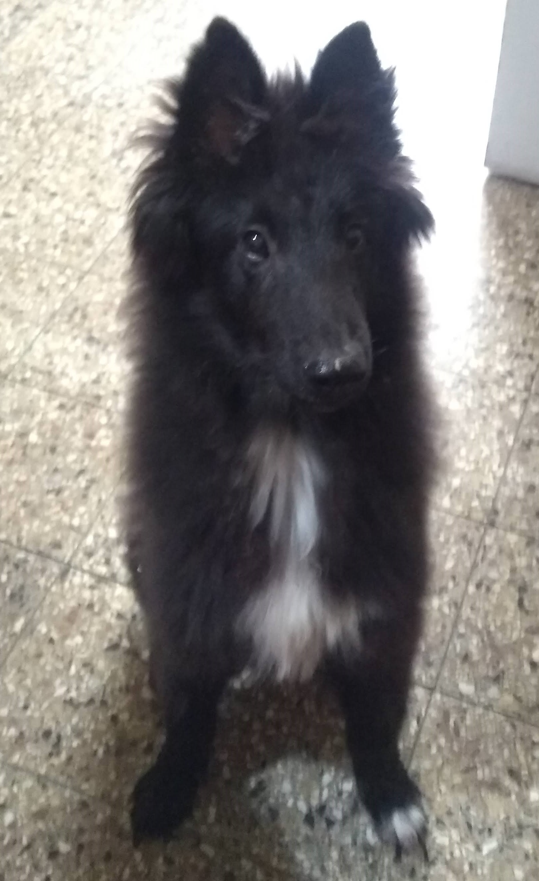

In [21]:
# a ver como se ve?

img = Image.open(fname)
width, height = img.size
img = img.resize((width//3,height//3))
img

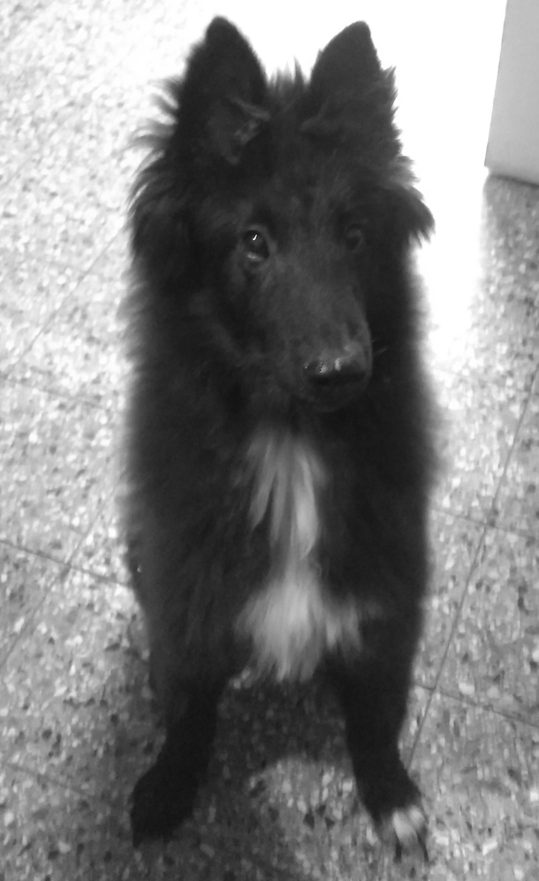

In [22]:
# la pasamos a blanco y negro

bw_img = img.convert('L')
bw_img

In [24]:
# ¿y la mencionada matriz a valores enteros cómo se obtiene?
# ...resulta que simplemente levantando el objeto PIL como un array de NumPy

img_array = np.array(bw_img)
img_array

array([[233, 232, 231, ..., 190, 190, 191],
       [225, 221, 219, ..., 190, 190, 191],
       [216, 218, 220, ..., 191, 190, 191],
       ...,
       [ 86,  88,  89, ..., 141, 140, 143],
       [ 85,  87,  88, ..., 145, 142, 142],
       [ 85,  82,  86, ..., 151, 146, 145]], dtype=uint8)

In [25]:
# ¿dimensiones de la matriz?
img_array.shape

(881, 539)

## Análisis de la SVD/DVS

Nos interesa no sólo aplicar la descomposición sino también analizar cómo se comportan los valores singulares. Dependiendo de esto último puede resultar interesante o no aplicar una reducción de dimensiones.

In [26]:
# aplicar la SVD/DVS en numpy es 1 línea de código
u, s, vh = np.linalg.svd(img_array, full_matrices=False)  # al poner full_matrices=False obtenemos la DVS compacta. Si no nos da la dvs por definicion

# ¿qué formas tienen?
u.shape, s.shape, vh.shape  # s es un vector de los elementos de la diagonal. No nos devuelve la matriz

((881, 539), (539,), (539, 539))

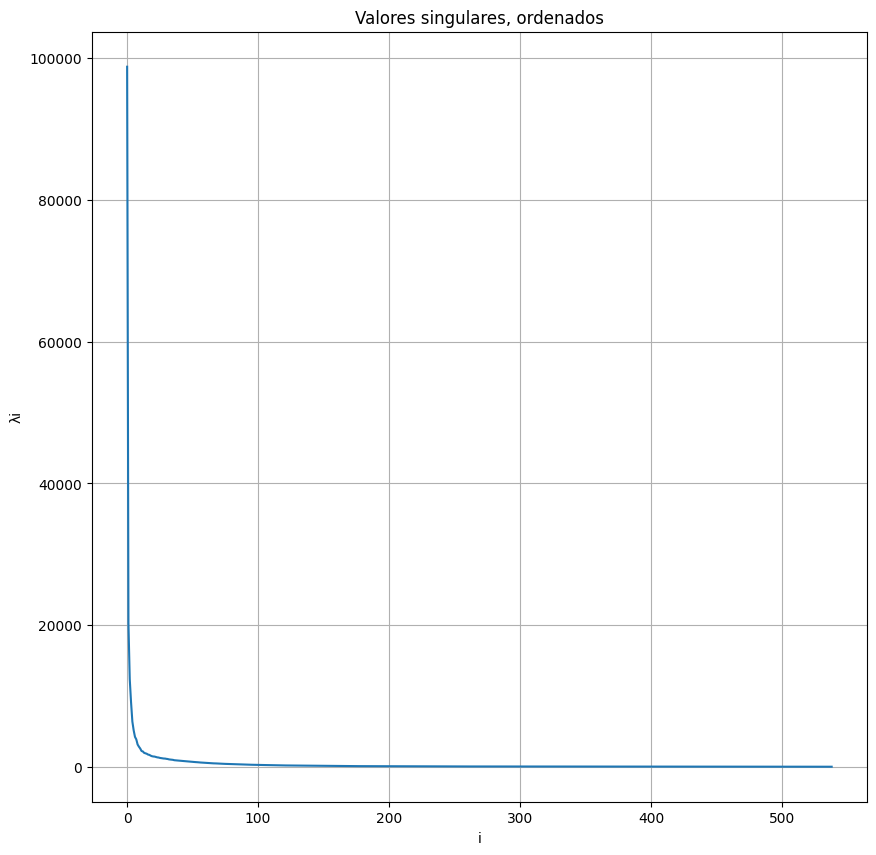

In [27]:
# Observemos los VSs

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(s)
ax.set_xlabel("i")
ax.set_ylabel("λi")
ax.set_title("Valores singulares, ordenados")
ax.grid(True)

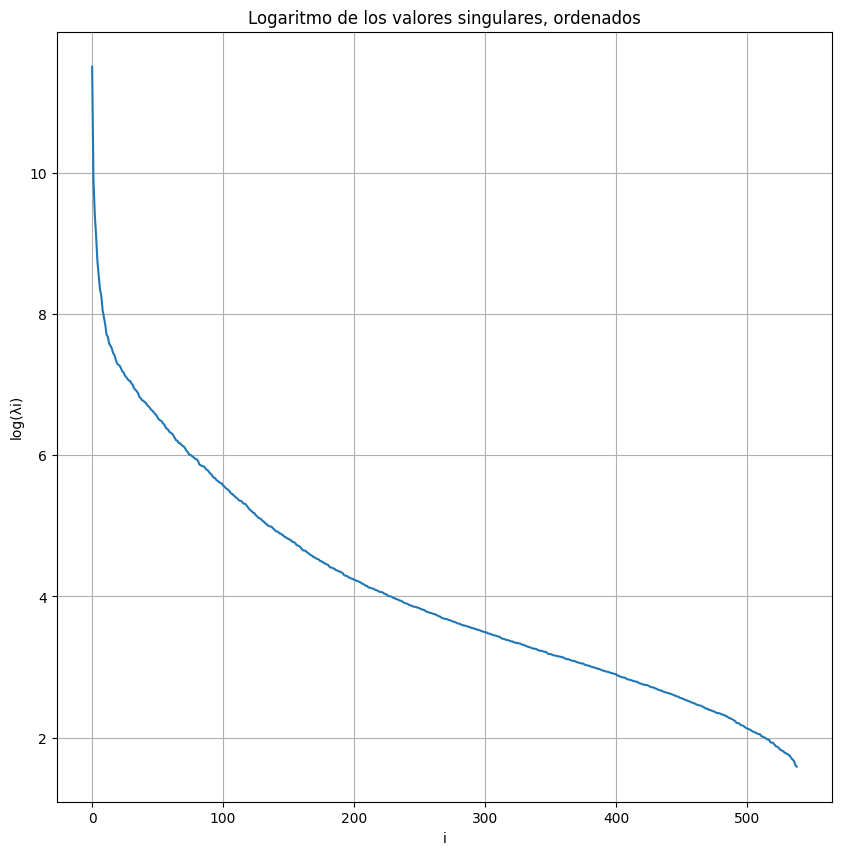

In [28]:
# valores muy grandes no permiten entender la distribución de los VSs

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(np.log(s))
ax.set_xlabel("i")
ax.set_ylabel("log(λi)")
ax.set_title("Logaritmo de los valores singulares, ordenados")
ax.grid(True)

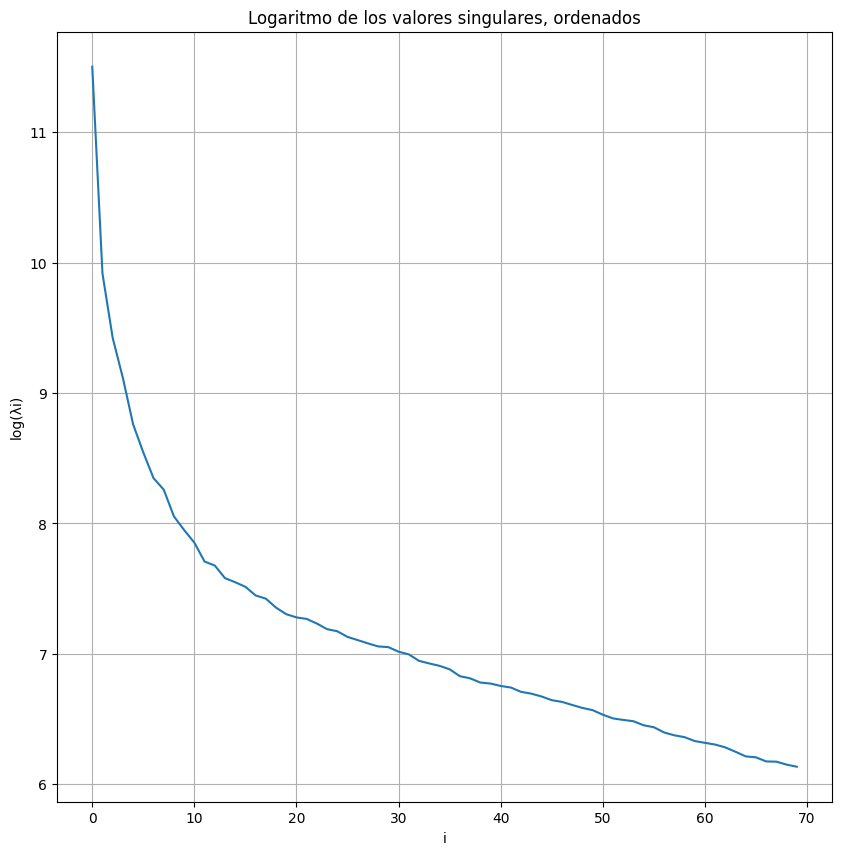

In [29]:
# hagamos zoom sobre los primeros 70, elegido arbitrariamente

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(np.log(s[:70]))
ax.set_xlabel("i")
ax.set_ylabel("log(λi)")
ax.set_title("Logaritmo de los valores singulares, ordenados")
ax.grid(True)

## Compresión de imágenes

Ahora que ya confirmamos que la distribución presenta el típico "codo" que nos interesa (es decir, que pocos valores singulares representan una fracción importante de la _energía_ de la matriz) podemos jugar con la reconstrucción de la imagen utilizando solamente los primeros $k$ valores.

Si originalmente
$U \in \mathbb{R}^{n \times s},
\Sigma \in \mathbb{R}^{s \times s},
V^T \in \mathbb{R}^{s \times m}$ entonces para un $k < s$ reconstruiremos la imagen utilizando
$U_{(\cdot, 1:k)} \in \mathbb{R}^{n \times k},
\Sigma_{(1:k, 1:k)} \in \mathbb{R}^{k \times k},
V^T_{(1:k, \cdot)} \in \mathbb{R}^{k \times m}$, es decir, con sólamente las primeras $k$ columnas de $U$, los primeros $k$ valores de $\Sigma$ y las primeras $k$ filas de $V^T$.

Si $k << s$ esto representa una importante reducción en el tamaño del objeto.

In [30]:
# definimos una función de utilidad para sólo utilizar los primeros k valores singulares

def recover_first_k(u,s,vh,k=None):
  # si k no fue especificado, utilizar reconstrucción completa
  if k==None:
    k = len(s)
  # asegurarnos que no se pasaron de k
  assert k <= len(s)
  # recomponer
  # recordar que los indices empiezan en 0 pero [:k] devuelve los idxs 0 a k-1...
  # ...así que terminan siendo los primeros k
  return u[:, :k] @ np.diag(s[:k]) @ vh[:k, :]   ## DVS TRUNCADA

In [31]:
# recuperación en crudo, sin usar la función
recovered = u @ np.diag(s) @ vh
recovered

array([[233., 232., 231., ..., 190., 190., 191.],
       [225., 221., 219., ..., 190., 190., 191.],
       [216., 218., 220., ..., 191., 190., 191.],
       ...,
       [ 86.,  88.,  89., ..., 141., 140., 143.],
       [ 85.,  87.,  88., ..., 145., 142., 142.],
       [ 85.,  82.,  86., ..., 151., 146., 145.]])

In [32]:
# chequeamos que de lo mismo que la reconstrucción de la función
recovered2 = recover_first_k(u,s,vh)
(recovered == recovered2).all() # todos los valores coinciden?

True

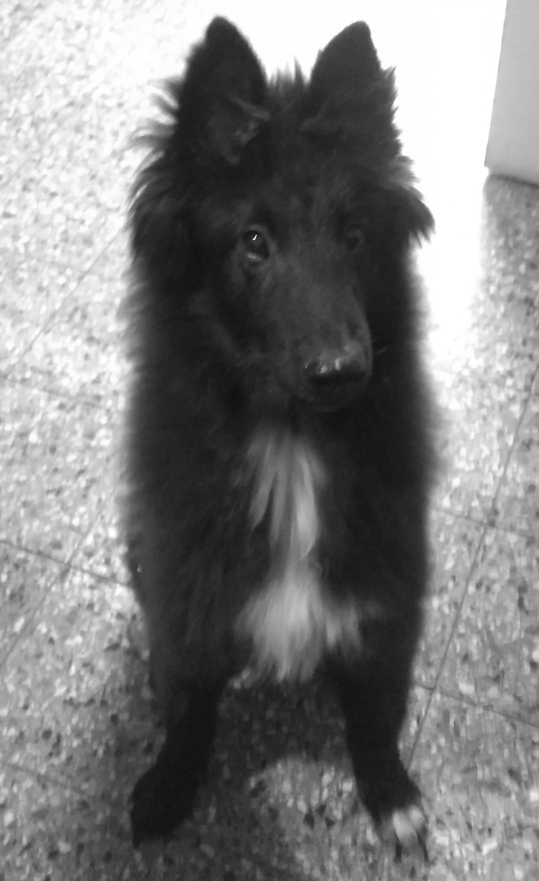

In [33]:
# se debería ver igual al original, lo chequeamos
rec_img = Image.fromarray(recovered.astype('uint8'))
rec_img

### $k=10$

Empecemos por un valor ínfimo de $k$ ($\frac{10}{539} \approx 1.86 \%$), que son solamente aquellos valores singulares pertenecientes al primer "codo".

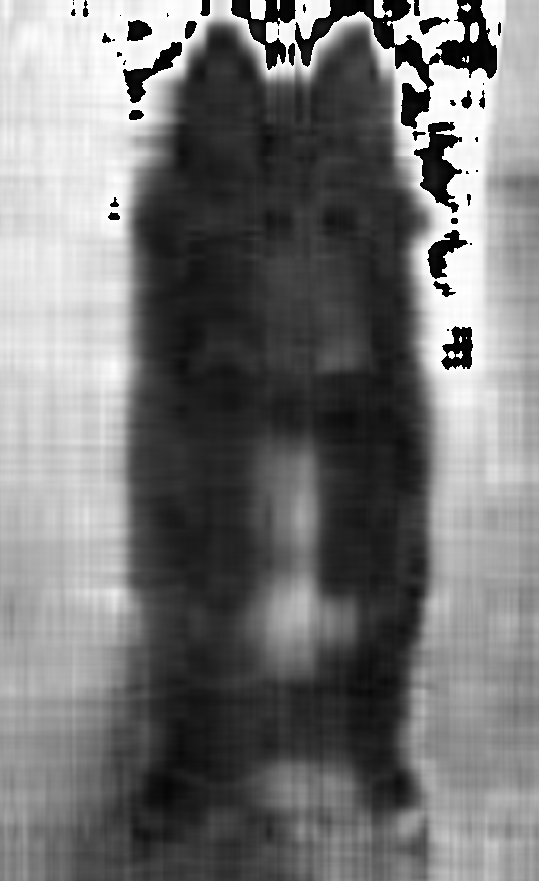

In [34]:
# vamos a mostrar con k=10, que es donde hace el codo
array10 = recover_first_k(u,s,vh, k = 10)
img10 = Image.fromarray(array10.astype('uint8'))
img10

### ¿Qué se ve con los otros 529 valores singulares?

Si no se sabe que es un perro, salvo por las orejas es casi imposible reconocerlo ¡y esto es utilizando $\frac{529}{539} \approx 98.14 \%$ de los valores singulares!

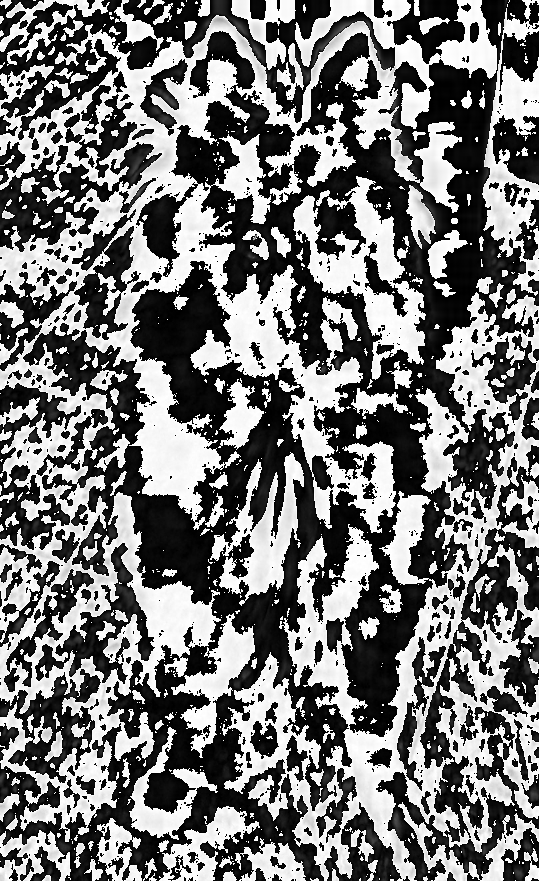

In [35]:
array_last10 = u[:, 10:] @ np.diag(s[10:]) @ vh[10:, :]
img_last_10 = Image.fromarray(array_last10.astype('uint8'))
img_last_10

### $k=100$

Analizando $k=10$ vemos dos cosas:

* Las siluetas ya se pueden apreciar
* La imagen aún así es muy borrosa

Tomamos ahora para un valor mayor de $k$ pero que siga representando una pequeña fracción de $s$, como lo es 100.

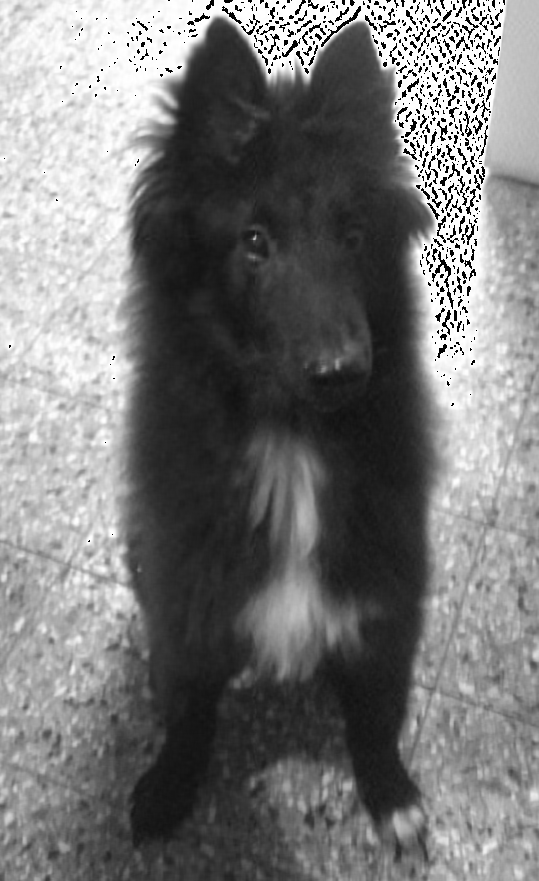

In [36]:
array100 = recover_first_k(u,s,vh, k = 100)
img100 = Image.fromarray(array100.astype('uint8'))
img100

### $k=300$

Con $k=100$ pudimos apreciar que el perro se distingue perfectamente (con una menor resolución); los mayores problemas ocurren en espacios que son "homogéneos". Dicho de forma coloquial, se manejan bien los espacios donde el color "varíe" pero no donde sea "constante".

Vamos a probar ahora con $k=300$, que corresponde al segundo "codo" tras el cual baja drásticamente la ganancia de energía.

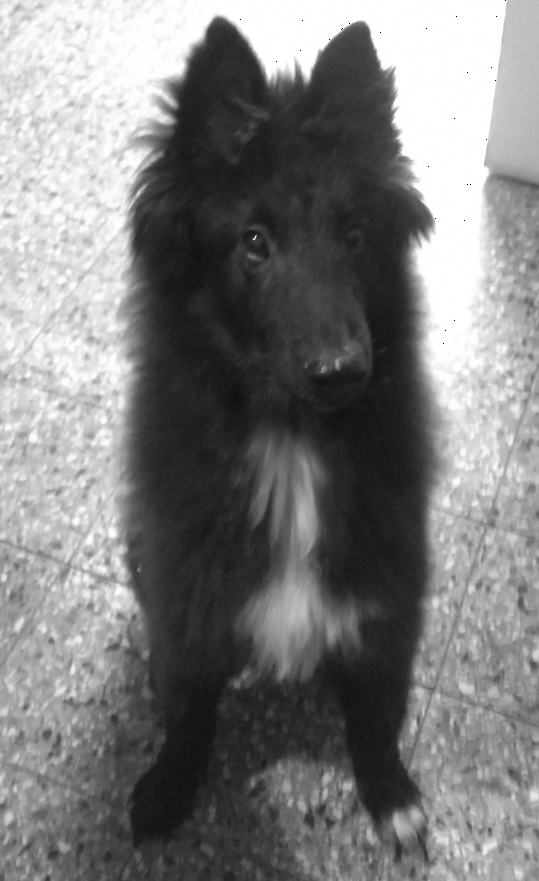

In [37]:
array300 = recover_first_k(u,s,vh, k = 300)
img300 = Image.fromarray(array300.astype('uint8'))
img300

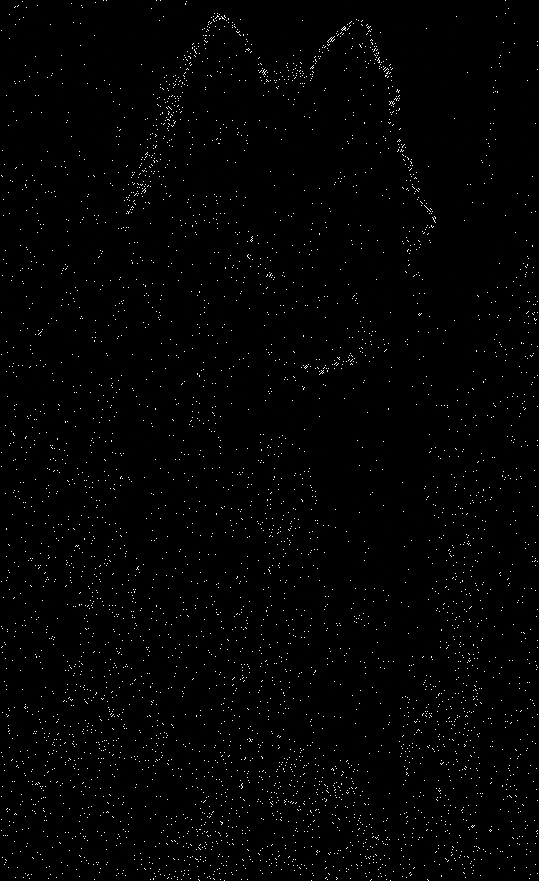

In [41]:
# más pruebas random

## Sacamos los primeros 300 autovalores más importantes

array_last10 = u[:, 300:] @ np.diag(s[300:]) @ vh[300:, :]
img_last_10 = Image.fromarray(array_last10.astype('uint8'))
img_last_10

## Conclusiones

Intencionalmente omitimos (hasta ahora) el siguiente gráfico que explica lo sucedido ¿Qué puede verse? ¿Qué otro valor de $k$ podría haber resultado interesante estudiar?

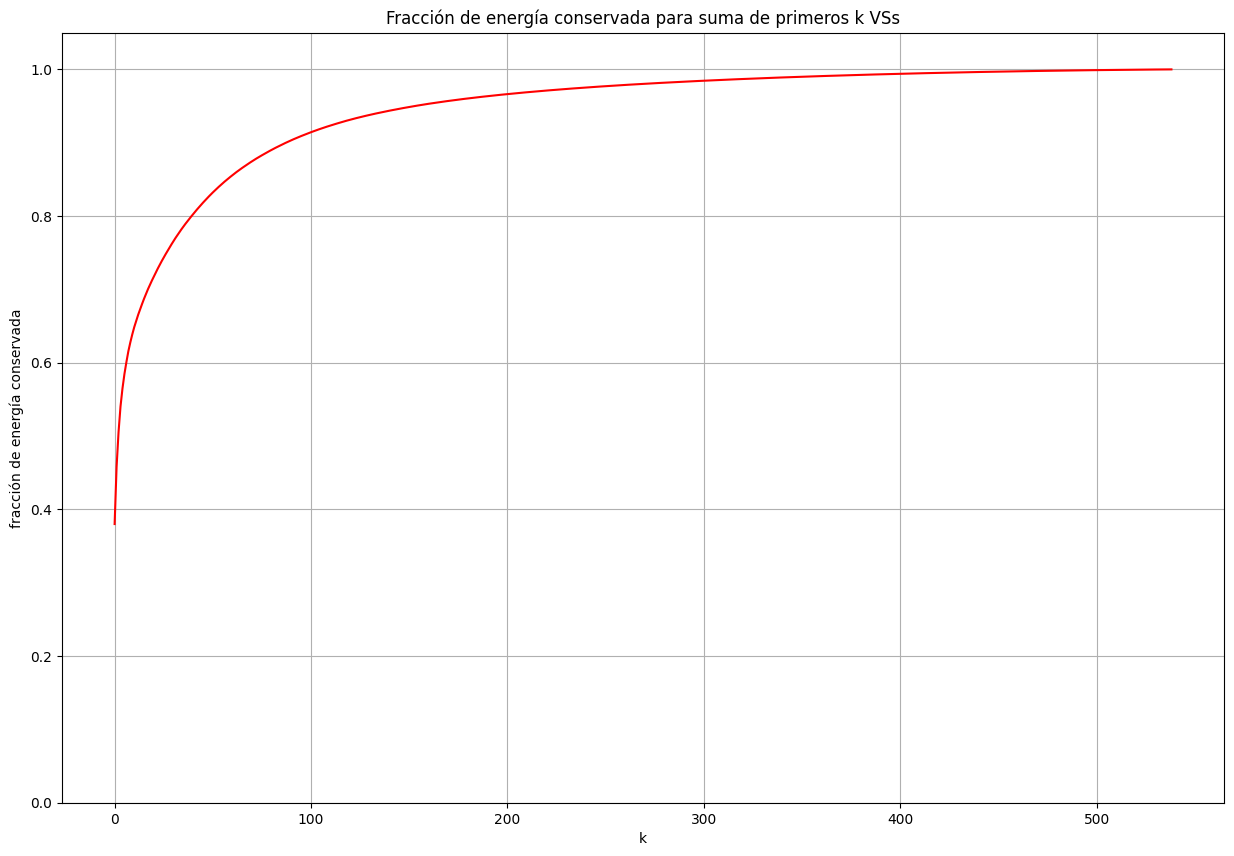

In [42]:
# Calculamos la energía acumulada para cada k primeros VSs, siendo la total la traza de la matriz sigma.
energy = np.cumsum(s)

coefs = energy / energy[-1]

fig, ax = plt.subplots(figsize=(15,10))

ax.plot(coefs, color='red')
ax.set_title("Fracción de energía conservada para suma de primeros k VSs")
ax.set_xlabel("k")
ax.set_ylabel("fracción de energía conservada")
ax.set_ylim((0,1.05))
ax.grid(True)